# jif3D Tutorial 4 -- joint inversion with mutual information

The inversion with cross-gradient coupling did not produce particularly satisfactory results. Even when we use a high constraint value, the models do not look that similar. This is because the cross-gradient defines a fairly weak form of similarity and it is actually one of its strenghts. It can be applied in a large variety of situations. However, there are cases such as this example where it does not appear to help very much. In my experience potential field data seems to be prone to this problem. We will therefore explore alternative coupling through mutual information (MI) and see what kind of models we can get from this.

Even though MI has been suggested to be used in joint inversion several years ago (the earliest I saw it mentioned is here: Haber, E., & Gazit, M. H. (2013). Model fusion and joint inversion. Surveys in Geophysics, 34(5), 675-695.). It is a new concept and only recently the first full joint inversion results with MI based coupling have been presented (https://youtu.be/Rfi0UwMTsMY). In this tutorial we will explore what joint inversion with a mutual information constraint can achieve.

## Mutual information in joint inversion

Generally speaking the mutual information $MI(\mathbf{x},\mathbf{y})$ between two variables $\mathbf{x}$ and $\mathbf{y}$ tells us how much knowing $\mathbf{x}$ lets us predict $\mathbf{y}$ and vice versa. If the mutual information is high, we have a strong correspondence between the two quantities, i.e. there is a one to one relationship. A low mutual information indicates that there is no strong relationship between the two variables. In that sense MI is a non-linear generalization of correlation. 

The short code below demonstrates both how to calculate mutual information and how no relationship (random scatter, left) produces a low mutual information and a functional relationship produces a higher MI value. Note though that the range of values is relatively small. Random scatter produces $MI \approx 1.3$ and a perfect relationship gives a value less than twice as high  $MI \approx 2.1$ (your exact values might differ due to the randon number generation). 

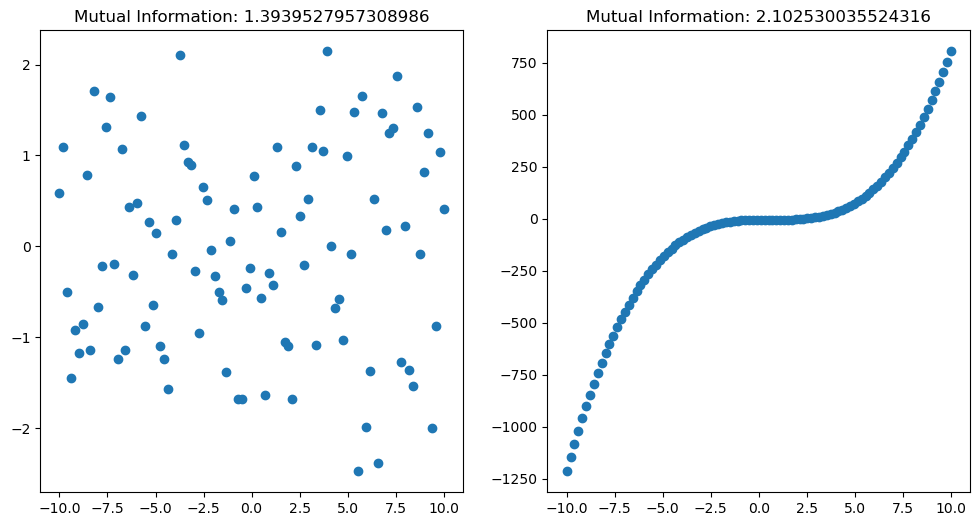

In [2]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt

def shan_entropy(c):
    #turn the bin counts into a pdf by normalizing 
    c_normalized = c / float(np.sum(c))
    #get rid of zero values as these cause issues in the log
    # however lim x->0 x log x = 0, so no problem in the maths
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    #calculate Shannon entropy
    H = -sum(c_normalized* np.log(c_normalized))  
    return H

def calc_MI(X,Y,bins):
   #calculate the values in each bin along each axis separately and on the whole plane
   c_XY = np.histogram2d(X,Y,bins)[0]
   c_X = np.histogram(X,bins)[0]
   c_Y = np.histogram(Y,bins)[0]
   #calculate the Shannon entropy for each distribution
   H_X = shan_entropy(c_X)
   H_Y = shan_entropy(c_Y)
   H_XY = shan_entropy(c_XY)
   #calculate mutual Information (MI)
   MI = H_X + H_Y - H_XY
   #and the associated metric variation of information (I)
   I = 2.0 * H_XY - H_X - H_Y
   return MI


x = np.linspace(-10,10,100)
y1 = np.random.randn(x.size)
y2 = x**3 - 2 * x**2 + x -5 
#calculate MI with 20 bins, changing that number will give slightly different results
mi1 = calc_MI(x,y1,20)
mi2 = calc_MI(x,y2,20)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x,y1)
plt.title("Mutual Information: {}".format(mi1))
plt.subplot(122)
plt.title("Mutual Information: {}".format(mi2))
plt.scatter(x,y2)
plt.show()

The above code also shows how to calculate MI
- Create an approximation to the 1D and 2D probability density functions (pdfs) by calculating histograms along each axis and a 2D histogram over the whole plane
- Calculate the Shannon Entropy $$ H(\mathbf{x}) = - \sum_{i=1}^N x_i \log(x_i) $$ for each of the pdfs
- Then we have $$MI = H(\mathbf{x}) + H(\mathbf{y}) - H(\mathbf{x},\mathbf{y})$$

To incorporate MI into joint inversion we have to design an objective function term $\Phi_{MI}$ similar to the cross-gradient term in Tutorial 3. The inversion aims to minimize the objective function, so we have to create a term that is "better" when it is smaller. Here we want to maximize mutual information, i.e. we want to uncover possible relationships between the parameters involved in the joint inversion, for example density and susceptibility. We could choose to use the negative of MI as an objective function term. This way smaller (more negative) values correspond to a stronger relationship. However, it appears to be more favorable to use an associated measure called variation of information
$$ I = 2  H(\mathbf{x},\mathbf{y}) - H(\mathbf{x}) - H(\mathbf{y}) = H(\mathbf{x}) + H(\mathbf{y}) - 2 MI. $$
This quantity decreases as the variables become more closely related. In addition, $I$ is a proper metric with is favorable in the context of inversion. Thus we use variation of information as the quantity to minimize in the inversion.

## Running the inversion
From a technical standpoint there is no significant difference to running the cross-gradient inversion or the inversion with mutual information. We specify the extra command line option *--mutual_information 100* to indicate to the code that we want to perform joint inversion with mutual information constraint where each axis is divided in 100 bins.

Due to the binning process we also have to consider the possible range of parameter values for each property. *jif3D* uses a constrained optimization approach through a parameter transformation (see Moorkamp, M., Heincke, B., Jegen, M., Roberts, A. W., & Hobbs, R. W. (2011). A framework for 3-D joint inversion of MT, gravity and seismic refraction data. Geophysical Journal International, 184(1), 477-493. for details). By default these parameter linits are relatively wide to be usable under most circumstances. However such wide parameter ranges also mean relatively wide bins for the MI calculation. If the real inversion parameters are in a much narrower range, many of the bins will be empty and all parameters of interest fall into a few broad bins. This will make the MI constraint less effective. We could increase the number of bins but this will also result in higher computational cost. So instead we limit the density and susceptibility range to values comparabel to the ones we saw in the results for the individual inversions. This can be achived with the *--mindens --maxdens --minsus --maxsus* command line parameters. Default values can be seen when calling the program with *--help*.

Looking carefully at the values below you will notice that the regularization values have been set much lower than previously. As we will see the variation of information constraint acts like a regularization, so it is my experience that a low smoothness regularization can be used and results in better models. 

In [10]:
#location of the jif3D executables on your system
execpath = "/home/max/workspace/jif3D/bin/"
#program we want to run
progname = "jointinv"
options = " --inclination 1.17 --declination 0.22 --fieldstrength 52671 --vi 100 --mindens -200 --maxdens 200 --minsus -0.4 --maxsus 0.4"
#name of the density starting mesh
gravmesh = "../Tutorial1/start_grav.nc"
#name of the gravity data file
gravdata = "../Tutorial1/gravdata.nc"
#name of the susecptibility starting mesh
magmesh = "../Tutorial2/start_mag.nc"
#name of the magnetics data file
magdata = "../Tutorial2/magdata.nc"
#weight for standard gravity data, set to 1
gravweight = 1.0
#weight for the magnetic data, set to zero at the moment as we do not have magnetic data yet
magweight = 1.0
#weight for the FTG data, set to zero at the moment as we do not have FTG data 
ftgweight = 0
magvectorweight = 0.0
mtweight = 0.0
dcweight = 0.0
tomographyweight = 0.0
surfacewaveweight = 0.0
#weight for the density regularization, now zero because we do not have density
gravregularization = 1.0
#weight for susceptibility regularization, this now controls smoothness
magregularization = 1.0
# weight for the coupling term, higher means stronger influence of MI constraint = more similar models
coupling = 1e5
#maximum number of iterations
iterations = 100
#write all information to file
f = open('run', 'w')
f.write(execpath+progname+options+" <<eof \n")    
f.write(magmesh+"\n")
f.write(str(gravweight)+"\n")
f.write(str(ftgweight)+"\n")
f.write(gravdata+"\n")
f.write(gravmesh+"\n")
f.write(str(magweight)+"\n")
f.write(magdata+"\n")
f.write(magmesh+"\n")
f.write(str(magvectorweight)+"\n")
f.write(str(mtweight)+"\n")
f.write(str(dcweight)+"\n")
f.write(str(tomographyweight)+"\n")
f.write(str(surfacewaveweight)+"\n")
f.write(str(coupling)+"\n")
f.write(str(gravregularization)+"\n")
f.write(str(magregularization)+"\n")
f.write(str(iterations)+"\n")
f.write("eof\n")
f.close()

Once we have specified the type of inversion, the files and weights, running the scripts works exactly as before.

In [11]:
import subprocess
outfile = open("jif3dmiout.out",'w')
subprocess.run(["bash ./run", ""],stdout=outfile,shell=True)
outfile.close()
log = open("jif3dmiout.out",'r')
for line in log:
    print(line)

 Found abort file, aborting Program ! 


Mesh filename: Scalar Gravimetry Lambda: FTG Lambda: Scalar Gravity Data Filename: Gravity Model Filename:  Model Z Origin: 0 larger than minimum data z-coordinate: -0.3

 Some scalar gravity data are outside modelling domain, inversion will run but might produce unexpected results ! 

Storing sensitivities in memory 

Storing sensitivities on disk 

Scalar gravity will take 0.821821 GB disk space 

Scalar Gravity ndata: 836

Scalar Gravity lambda: 1

Setting global covariance for Density

Total field magnetics Lambda: Total field magnetic Data Filename: Susceptibility Model Filename:  Model Z Origin: 0 larger than minimum data z-coordinate: -10000

 Some data are outside modelling domain, inversion will run but might produce unexpected results ! 

Storing sensitivities in memory 

Storing sensitivities on disk 

Magnetics will take 2.44777 GB disk space 

 Magnetics ndata: 830

 Magnetics lambda: 1

Setting global covariance for Susceptibility

3-component magnetization Lambda: MT Lam

We use the same plotting script as for the cross-gradient inversion. The organization of the *misfit.out* and *rms.out* files is exactly the same only that the cross-gradient values have been replaced by variation of information. 

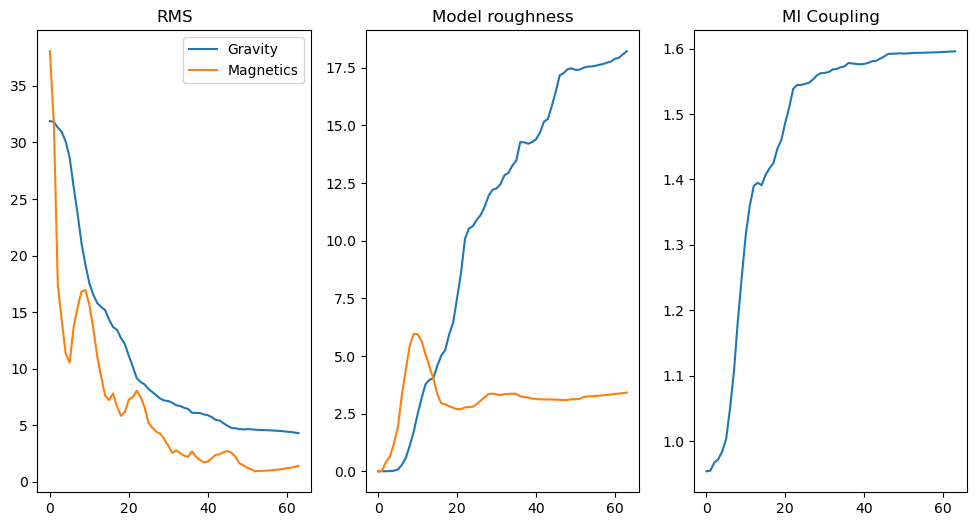

In [12]:
misfit = np.genfromtxt("misfit.out")
rms = np.genfromtxt("rms.out")
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(rms[:,1],label='Gravity')
plt.plot(rms[:,2],label='Magnetics')
plt.legend()
plt.title("RMS")
plt.subplot(132)
plt.plot(misfit[:,5])
plt.plot(misfit[:,6])
plt.title("Model roughness")
plt.subplot(133)
plt.plot(misfit[:,4])
plt.title("MI Coupling")
plt.show()

With the settings above we significantly reduce the data misfit for both datasets initially. However, after 20 iterations the gravity data misfit increases again and stabilizes at an RMS of approximately 5. This coincides with the reduction of the coupling constraint. This indicates that the enforced relationship is in conflict with some aspects fo the data. As we have seen with the cross-gradient though this can be related to small near-surface structures. We have seen that these can require strong heterogeneity where each cell show different values and thus act as noise to the joint inversion. Before we discuss strategies to mitigate this, we examine the intermediate results we currently have.

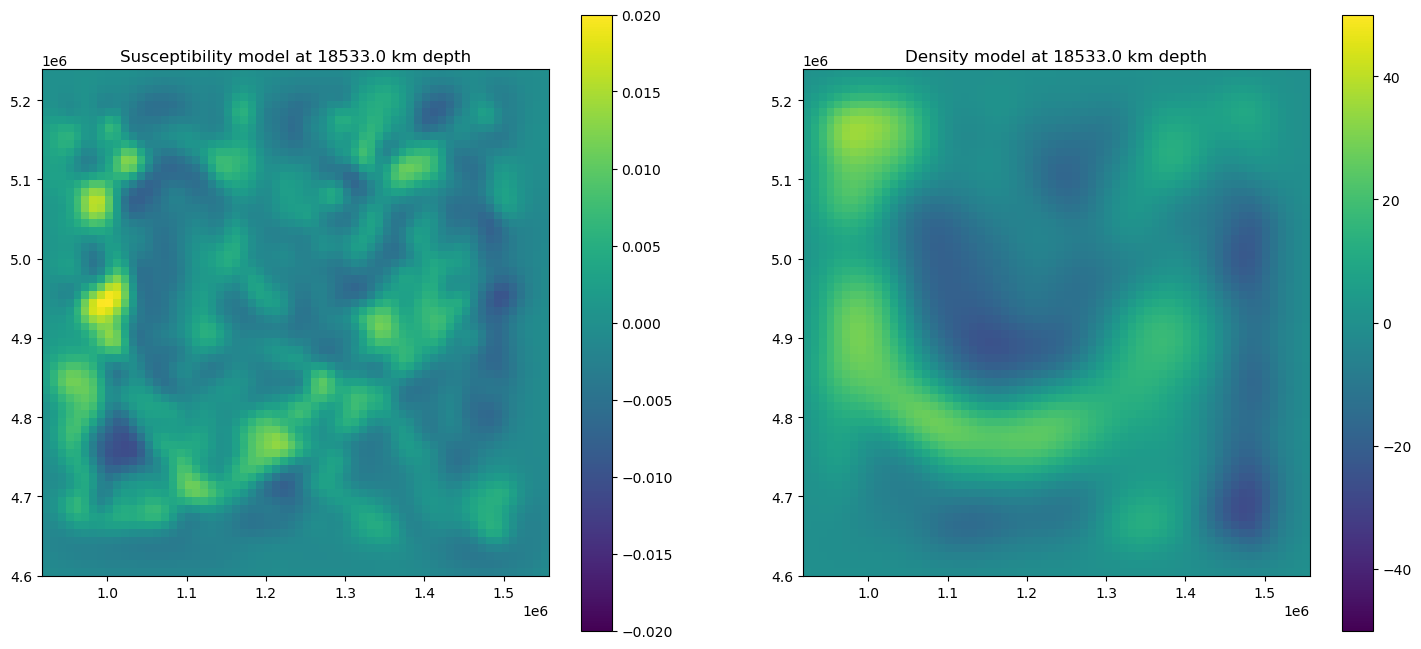

In [13]:
#the index of horizontal layer we want to plot, larger numbers = deeper, maximum 29 (nz-1)
depthindex = 10

#read in magnetic inversion model
mag_fh = Dataset("result.mag.inv.nc")
Northing =mag_fh.variables["Northing"][:]
Easting =mag_fh.variables["Easting"][:]
Depth =mag_fh.variables["Depth"][:]
Northing_Origin =mag_fh.variables["Northing_Origin"][:]
Easting_Origin =mag_fh.variables["Easting_Origin"][:]
Depth_Origin =mag_fh.variables["Depth_Origin"][:]
invsus = mag_fh.variables["Susceptibility"][:,:,:]
mag_fh.close()

#and the corresponding gravity model, do not need geometry as we know it is the same
grav_fh = Dataset("result.grav.inv.nc")
invdens = grav_fh.variables["Density"][:,:,:]
grav_fh.close()

pe = np.append(Easting_Origin,Easting)
pn = np.append(Northing_Origin,Northing)
pd = np.append(Depth_Origin,Depth)

plt.figure(figsize = (18,8))
plt.subplot(121)
mx, my = np.meshgrid(pe,pn)
psus = np.transpose(invsus[depthindex,:,:])
plt.pcolormesh(mx,my,psus,vmin=-0.02,vmax=0.02)
plt.title("Susceptibility model at {} km depth".format(Depth[depthindex]))
plt.gca().set_aspect(1)
plt.colorbar()

plt.subplot(122)
pdens = np.transpose(invdens[depthindex,:,:])
plt.pcolormesh(mx,my,pdens,vmin=-50,vmax=50)
plt.title("Density model at {} km depth".format(Depth[depthindex]))
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

The visual appearance of these models is very different to the individual models and the cross-gradient results. One reason is the aforementioned way the MI-coupling acts as a regularization. It tends to favour large regions of near constant value and does not penalize abrupt parameter changes as long as they occur with some spatial coherence. Thus the models have a much more blocky appearance which in some cases makes them look more geological. More importantly though, we see direct correspondance between structures in both models, so the joint inversion has create similar looking models. 

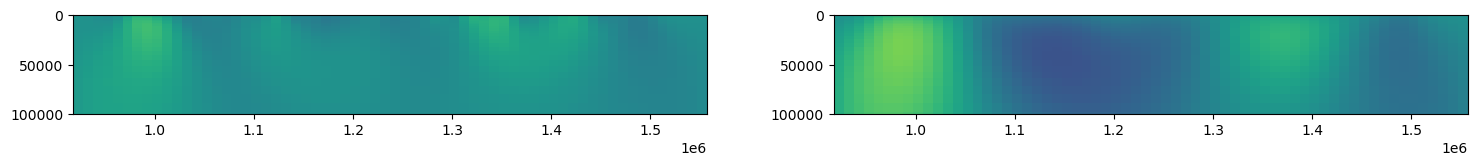

In [14]:
#the index of the East-West slice, larger numbers = further north, maximum 63 (nx-1)
northindex = 32
plt.figure(figsize = (18,8))

plt.subplot(121)
mx, my = np.meshgrid(pe,pd)
plt.pcolormesh(mx,my,invsus[:,:,northindex],vmin=-0.04,vmax=0.04)
plt.ylim([100000,0])
plt.gca().set_aspect(1)

plt.subplot(122)
plt.pcolormesh(mx,my,invdens[:,:,northindex],vmin=-50,vmax=50)
plt.ylim([100000,0])
plt.gca().set_aspect(1)
plt.show()

Vertical slices through the model confirm the above impression and we can see more focused anomalies that are restricted in depth. Still there are some structures that extend through the whole model domain (e.g. at the leaft/western end of the profile).

We can also look at the parameter relationship retrieved by the inversion. In contrast to cross-gradient the coupling is now designed to extract some generalized functional relationship. We can see from the two plots that it is at least partially achieved.

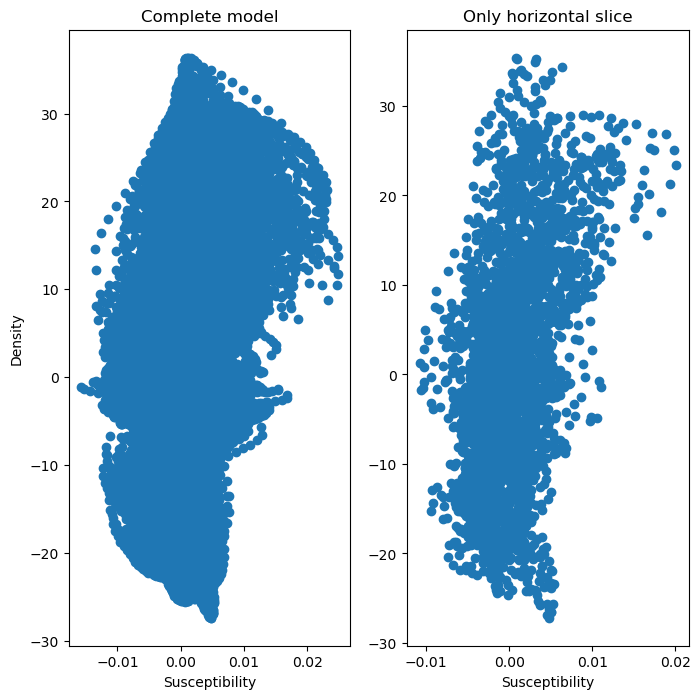

In [15]:
plt.figure(figsize = (8,8))
plt.subplot(121)
plt.scatter(invsus.flatten(),invdens.flatten())
plt.title("Complete model")
plt.xlabel("Susceptibility")
plt.ylabel("Density")
plt.subplot(122)
plt.scatter(psus.flatten(),pdens.flatten())
plt.title("Only horizontal slice")
plt.xlabel("Susceptibility")
plt.show()

The density-susceptibility cross-plot across the whole model domain (left) shows an interesting star shape appearance. With some identifiable trends. There is some background scatter wich is likely related to near surface structures. When we look at the relationship within a single slice (right), we can see some clear clustering at depth. Note the different axis range for both plots.

## Improving the results

The first inversion with mutual information has given some interesting results and first hints at possible parameter relationships. However we do not fit the data to satisfactory degree. There are various routes we can take to achieve this:

- Rerun with a different coupling weight and/or regularization
- Carefully investigate the errors and data to see if the other inversions maybe overfit the data
- Exclude parts of the model (e.g. near-surface) from the joint inversion (requires in-depth modifications)
- Continue with final model from this inversion and a lower coupling weight

All these strategies are potentially useful and in a full scale project one should always pursue all possibilities until it is clear what is causing the issue. In this tutorial we will briefly look at the last strategy (continue with a smaller weight) as this has been quite successful in practice. We start with a high coupling term to make sure that the datasets interact and continue until no more improvement can be made. Then we relax the constraint just enough to continue the convergence of the data misfit until we reach the required RMS. While this procedure can be lengthy and a bit tedious, I have achieved good results in the past.

Given the time it takes for the inversion to run, I have precomputed results with a MI weight of 10,000, i.e. a factor of ten smaller. With that we get close to a satisfactory fit. The informatio  in the plots below is identical to the previous plots only with this inversion run, so it should be easy to understand what is shown

## Tasks
Investigate the plots below.
- What do you conclude in terms of data misfit?
- Do the structures make any sense?
- What about the density-susceptibility relationship?
- How should we proceed?

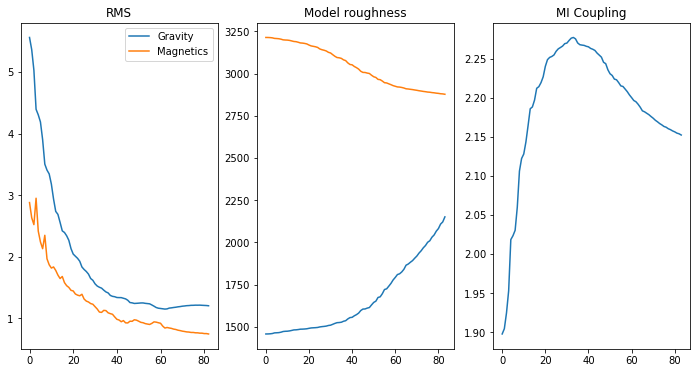

In [66]:
misfit = np.genfromtxt("mi1e4/misfit.out")
rms = np.genfromtxt("mi1e4/rms.out")
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(rms[:,1],label='Gravity')
plt.plot(rms[:,2],label='Magnetics')
plt.legend()
plt.title("RMS")
plt.subplot(132)
plt.plot(misfit[:,4])
plt.plot(misfit[:,5])
plt.title("Model roughness")
plt.subplot(133)
plt.plot(misfit[:,6])
plt.title("MI Coupling")
plt.show()

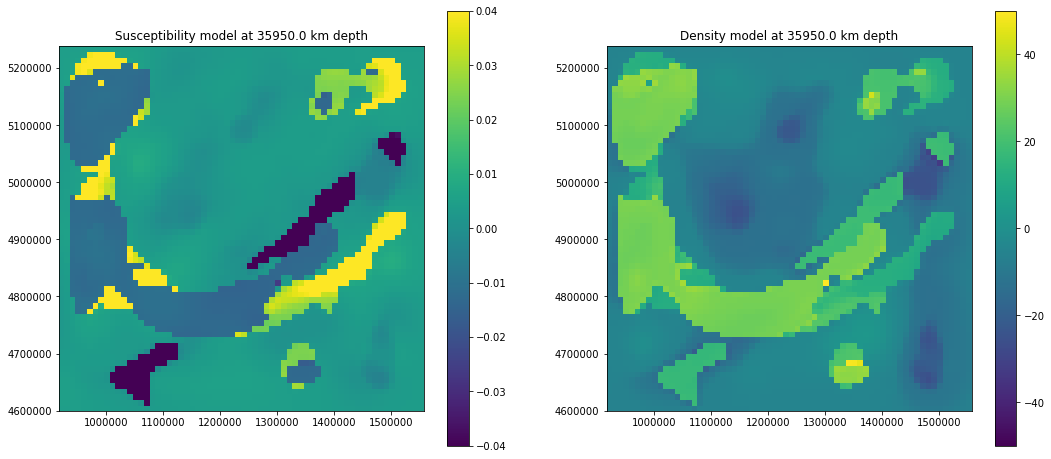

In [67]:
#the index of horizontal layer we want to plot, larger numbers = deeper, maximum 29 (nz-1)
depthindex = 15
#the index of the East-West slice, larger numbers = further north, maximum 63 (nx-1)
northindex = 32
#read in inversion model
mag_fh = Dataset("mi1e4/result.mag.inv.nc")
Northing =mag_fh.variables["Northing"][:]
Easting =mag_fh.variables["Easting"][:]
Depth =mag_fh.variables["Depth"][:]
Northing_Origin =mag_fh.variables["Northing_Origin"][:]
Easting_Origin =mag_fh.variables["Easting_Origin"][:]
Depth_Origin =mag_fh.variables["Depth_Origin"][:]
invsus = mag_fh.variables["Susceptibility"][:,:,:]
mag_fh.close()

grav_fh = Dataset("mi1e4/result.grav.inv.nc")
invdens = grav_fh.variables["Density"][:,:,:]
grav_fh.close()

pe = np.append(Easting_Origin,Easting)
pn = np.append(Northing_Origin,Northing)
pd = np.append(Depth_Origin,Depth)

plt.figure(figsize = (18,8))
plt.subplot(121)
mx, my = np.meshgrid(pe,pn)
psus = np.transpose(invsus[depthindex,:,:])
plt.pcolormesh(mx,my,psus,vmin=-0.04,vmax=0.04)
plt.title("Susceptibility model at {} km depth".format(Depth[depthindex]))
plt.gca().set_aspect(1)
plt.colorbar()

plt.subplot(122)
pdens = np.transpose(invdens[depthindex,:,:])
plt.pcolormesh(mx,my,pdens,vmin=-50,vmax=50)
plt.title("Density model at {} km depth".format(Depth[depthindex]))
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

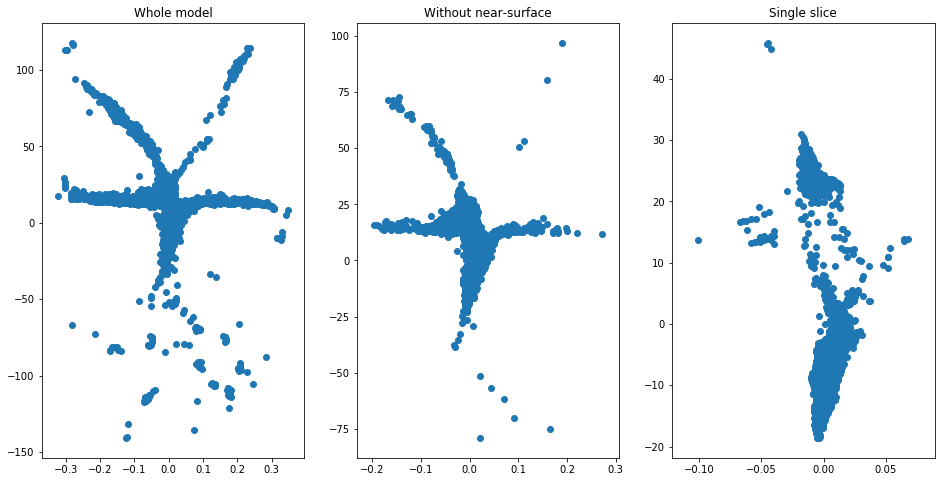

In [82]:
plt.figure(figsize = (16,8))
plt.subplot(131)
plt.scatter(invsus.flatten(),invdens.flatten())
plt.title("Whole model")
plt.subplot(132)
plt.scatter(invsus[3:,:,:].flatten(),invdens[3:,:,:].flatten())
plt.title("Without near-surface")
plt.subplot(133)
plt.scatter(psus.flatten(),pdens.flatten())
plt.title("Single slice")
plt.show()